# Import Library


In [ ]:
!pip -q install kagglehub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers


In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


#Load Data

In [ ]:
import kagglehub

DATA_DIR = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")
print("Dataset path:", DATA_DIR)

csv_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))

csv_files = sorted(csv_files)
print("CSV files:", len(csv_files))
print("Example:", csv_files[:5])


100%|██████████| 1.24M/1.24M [00:00<00:00, 54.4MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1
CSV files: 35
Example: ['/root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/anomaly-free/anomaly-free.csv', '/root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/other/11.csv', '/root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/other/12.csv', '/root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/other/13.csv', '/root/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/other/14.csv']


# EDA

In [ ]:
def read_skab_csv(fp: str) -> pd.DataFrame:
    # coba ; dulu, fallback ke ,
    try:
        df = pd.read_csv(fp, sep=";")
        if df.shape[1] == 1:
            df = pd.read_csv(fp, sep=",")
    except Exception:
        df = pd.read_csv(fp, sep=",")
    return df

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # samakan nama kolom flow rate yang kadang beda
    if "Volume Flow RateRMS" in df.columns and "RateRMS" not in df.columns:
        df = df.rename(columns={"Volume Flow RateRMS": "RateRMS"})
    if "Volume Flow RateRMS " in df.columns and "RateRMS" not in df.columns:
        df = df.rename(columns={"Volume Flow RateRMS ": "RateRMS"})
    return df

dfs = []
for fp in csv_files:
    df = standardize_columns(read_skab_csv(fp))
    df["file_id"] = os.path.relpath(fp, DATA_DIR)  # simpan path relatif biar unik
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
display(data.head())


Shape: (46860, 12)
Columns: ['datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'RateRMS', 'file_id', 'anomaly', 'changepoint']


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,RateRMS,file_id,anomaly,changepoint
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,SKAB/anomaly-free/anomaly-free.csv,NaN,NaN
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,SKAB/anomaly-free/anomaly-free.csv,NaN,NaN
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,SKAB/anomaly-free/anomaly-free.csv,NaN,NaN
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,SKAB/anomaly-free/anomaly-free.csv,NaN,NaN
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,SKAB/anomaly-free/anomaly-free.csv,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
display(data.head(5))

# Info ringkas
print("\nDtypes:")
print(data.dtypes)

# Cek duplikat baris
dup = data.duplicated().sum()
print("\nDuplicate rows:", dup)


Shape: (46860, 12)
Columns: ['datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'RateRMS', 'file_id', 'anomaly', 'changepoint']


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,RateRMS,file_id,anomaly,changepoint
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,SKAB/anomaly-free/anomaly-free.csv,0,0
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,SKAB/anomaly-free/anomaly-free.csv,0,0
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,SKAB/anomaly-free/anomaly-free.csv,0,0
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,SKAB/anomaly-free/anomaly-free.csv,0,0
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,SKAB/anomaly-free/anomaly-free.csv,0,0



Dtypes:
datetime              object
Accelerometer1RMS    float64
Accelerometer2RMS    float64
Current              float64
Pressure             float64
Temperature          float64
Thermocouple         float64
Voltage              float64
RateRMS              float64
file_id               object
anomaly                int32
changepoint            int32
dtype: object

Duplicate rows: 0


In [ ]:
# Missing values per kolom
missing = data.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(data) * 100).round(3)
miss_df = pd.DataFrame({"missing": missing, "missing_%": missing_pct})

display(miss_df.head(15))

# Pastikan label anomaly: NaN dianggap normal
anom_raw = pd.to_numeric(data["anomaly"], errors="coerce")
print("anomaly NaN count:", int(anom_raw.isna().sum()))
print("anomaly unique after fillna(0):", np.unique(anom_raw.fillna(0).astype(int)))


,missing,missing_%
datetime,0,0.0
Accelerometer1RMS,0,0.0
Accelerometer2RMS,0,0.0
Current,0,0.0
Pressure,0,0.0
Temperature,0,0.0
Thermocouple,0,0.0
Voltage,0,0.0
RateRMS,0,0.0
file_id,0,0.0


anomaly NaN count: 0
anomaly unique after fillna(0): [0 1]


Timestep label counts: [33619 13241]
Anomaly rate: 0.28256508749466497


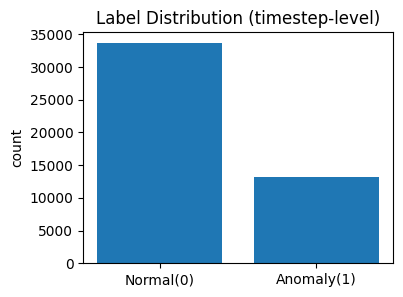

In [ ]:
import matplotlib.pyplot as plt

y_ts = pd.to_numeric(data["anomaly"], errors="coerce").fillna(0).astype(int).values

counts = np.bincount(y_ts)
print("Timestep label counts:", counts)
print("Anomaly rate:", y_ts.mean())

plt.figure(figsize=(4,3))
plt.bar(["Normal(0)","Anomaly(1)"], counts)
plt.title("Label Distribution (timestep-level)")
plt.ylabel("count")
plt.show()


,count,anom_count,anom_rate
file_id,,,
SKAB/other/11.csv,665,384,0.577444
SKAB/other/19.csv,1326,587,0.442685
SKAB/other/13.csv,968,398,0.411157
SKAB/valve2/3.csv,995,395,0.396985
SKAB/other/20.csv,1191,451,0.378673
SKAB/valve1/7.csv,1094,405,0.370201
SKAB/other/14.csv,1153,410,0.355594
SKAB/valve1/3.csv,1149,404,0.351610
SKAB/other/21.csv,1141,401,0.351446


Files total: 35
Files with anomaly: 34


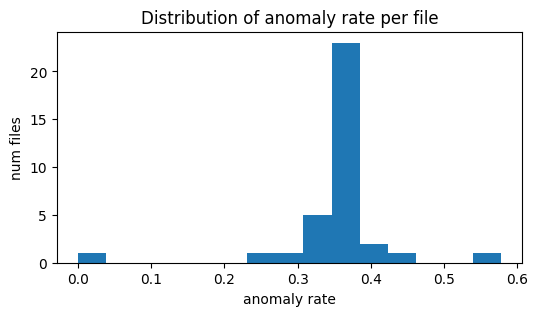

In [ ]:
file_stats = (
    data.groupby("file_id")["anomaly"]
    .apply(lambda s: pd.to_numeric(s, errors="coerce").fillna(0).astype(int))
    .groupby(level=0)
    .agg(["count","sum","mean"])
    .rename(columns={"sum":"anom_count","mean":"anom_rate"})
    .sort_values("anom_rate", ascending=False)
)

display(file_stats.head(12))

print("Files total:", len(file_stats))
print("Files with anomaly:", int((file_stats["anom_count"] > 0).sum()))

import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(file_stats["anom_rate"], bins=15)
plt.title("Distribution of anomaly rate per file")
plt.xlabel("anomaly rate")
plt.ylabel("num files")
plt.show()


In [ ]:
X_num = data[feature_cols].apply(pd.to_numeric, errors="coerce")

desc = X_num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
display(desc)

# IQR outlier rate (kasar, buat narasi)
q1 = X_num.quantile(0.25)
q3 = X_num.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
outlier_rate = ((X_num < lower) | (X_num > upper)).mean().sort_values(ascending=False)

display(outlier_rate.to_frame("outlier_rate_IQR").head(10))


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Accelerometer1RMS,46860.0,0.130007,0.126100,0.000000,0.026294,0.026717,0.027436,0.080429,0.215797,0.251299,0.640512,0.722747
Accelerometer2RMS,46860.0,0.163594,0.144181,0.000000,0.038075,0.038974,0.040407,0.130242,0.268833,0.298210,0.718686,0.800498
Current,46860.0,1.834006,6.333487,0.355411,0.456345,0.613507,0.982954,1.376230,2.484310,2.911984,3.112292,243.829000
Pressure,46860.0,0.080226,0.259530,-1.257000,-0.601143,-0.273216,0.054711,0.054711,0.382638,0.382638,0.710565,1.694350
Temperature,46860.0,79.361782,9.403996,65.089000,66.213777,67.352275,69.511200,84.975450,88.620850,90.155030,92.478883,95.011400
Thermocouple,46860.0,26.576258,2.539642,22.020900,22.084059,22.124600,24.650000,25.609600,29.157000,29.923925,31.789802,33.415100
Voltage,46860.0,229.398906,12.677240,0.580776,204.290080,208.395000,223.545000,229.845000,235.923250,249.173300,253.177230,255.324000
RateRMS,46860.0,75.267382,45.839564,0.000000,21.976999,28.975000,32.000000,72.021400,126.000000,128.000000,129.694000,133.688000


,outlier_rate_IQR
Pressure,0.027038
Accelerometer1RMS,0.026825
Accelerometer2RMS,0.026120
Voltage,0.016219
Current,0.000768
Temperature,0.000000
Thermocouple,0.000000
RateRMS,0.000000


/tmp/ipython-input-1177910863.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_num = data[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0)


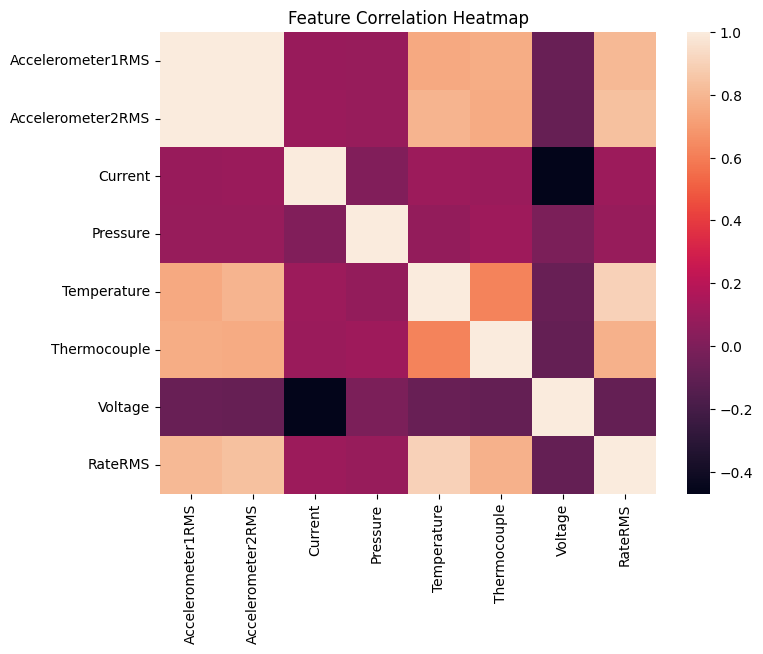

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

X_num = data[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0)
corr = X_num.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# Data Preparation

In [ ]:
LABEL_COL = "anomaly"
GROUP_COL = "file_id"

if LABEL_COL not in data.columns:
    raise ValueError(f"Kolom '{LABEL_COL}' tidak ditemukan. Cek data.columns.")

# Label: anomaly-free sering NaN → normal (0)
data[LABEL_COL] = pd.to_numeric(data[LABEL_COL], errors="coerce").fillna(0).astype("int32")

# changepoint optional
if "changepoint" in data.columns:
    data["changepoint"] = pd.to_numeric(data["changepoint"], errors="coerce").fillna(0).astype("int32")

# Drop non-feature
drop_cols = {LABEL_COL, GROUP_COL}
if "changepoint" in data.columns:
    drop_cols.add("changepoint")
if "datetime" in data.columns:
    drop_cols.add("datetime")

feature_cols = [c for c in data.columns if c not in drop_cols]

# Pastikan numeric
X_all = data[feature_cols].apply(pd.to_numeric, errors="coerce")
X_all = X_all.fillna(method="ffill").fillna(0).astype("float32")

y_all = data[LABEL_COL].values
groups = data[GROUP_COL].values

print("Num features:", len(feature_cols))
print("Anomaly rate (timestep):", float(y_all.mean()))
print("Label bincount:", np.bincount(y_all))


Num features: 8
Anomaly rate (timestep): 0.28256508749466497
Label bincount: [33619 13241]


/tmp/ipython-input-395401239.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_all = X_all.fillna(method="ffill").fillna(0).astype("float32")


In [ ]:
file_stats = (
    data.groupby("file_id")[LABEL_COL]
    .agg(["count", "sum", "mean"])
    .rename(columns={"sum": "anom_count", "mean": "anom_rate"})
    .sort_values("anom_rate", ascending=False)
)
display(file_stats.head(12))
print("Files with anomaly:", int((file_stats["anom_count"] > 0).sum()), "/", len(file_stats))


,count,anom_count,anom_rate
file_id,,,
SKAB/other/11.csv,665,384,0.577444
SKAB/other/19.csv,1326,587,0.442685
SKAB/other/13.csv,968,398,0.411157
SKAB/valve2/3.csv,995,395,0.396985
SKAB/other/20.csv,1191,451,0.378673
SKAB/valve1/7.csv,1094,405,0.370201
SKAB/other/14.csv,1153,410,0.355594
SKAB/valve1/3.csv,1149,404,0.351610
SKAB/other/21.csv,1141,401,0.351446


Files with anomaly: 34 / 35


In [ ]:
SEQ_LEN = 80
STRIDE = 1
def make_windows_by_file(X_df, y_ts, groups, seq_len=80, stride=1, min_anom_ratio=0.57):
    Xw, yw = [], []
    for fid in np.unique(groups):
        mask = (groups == fid)
        X_f = X_df.loc[mask].values
        y_f = y_ts[mask]
        T = len(X_f)
        if T < seq_len:
            continue

        for start in range(0, T - seq_len + 1, stride):
            end = start + seq_len
            window_y = y_f[start:end]
            anom_ratio = window_y.mean()
            Xw.append(X_f[start:end])
            yw.append(int(anom_ratio >= min_anom_ratio))
    return np.array(Xw, dtype=np.float32), np.array(yw, dtype=np.int32)



In [ ]:
def split_by_file_valid_windows(X_all_df, y_all_ts, groups_all,
                                test_size=0.2, seed=42, max_tries=400):
    unique_files = np.unique(groups_all)

    # label file: apakah file mengandung anomaly timestep
    file_has_anom = {fid: int(y_all_ts[groups_all == fid].sum() > 0) for fid in unique_files}
    file_labels = np.array([file_has_anom[fid] for fid in unique_files])

    # kita split file-level dulu, lalu cek window-level class presence
    for i in range(max_tries):
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed+i)
        idx = np.arange(len(unique_files))
        tr_fi, te_fi = next(gss.split(idx, file_labels, groups=unique_files))

        train_files = unique_files[tr_fi]
        test_files  = unique_files[te_fi]

        tr_mask = np.isin(groups_all, train_files)
        te_mask = np.isin(groups_all, test_files)

        X_train_df = X_all_df.loc[tr_mask].copy()
        X_test_df  = X_all_df.loc[te_mask].copy()
        y_train_ts = y_all_ts[tr_mask]
        y_test_ts  = y_all_ts[te_mask]
        g_train    = groups_all[tr_mask]
        g_test     = groups_all[te_mask]

        # scaling (fit only train) supaya windowing cek realistis
        scaler = MinMaxScaler()
        X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
        X_test_sc  = pd.DataFrame(scaler.transform(X_test_df),  columns=X_test_df.columns)

        X_train_w, y_train_w = make_windows_by_file(X_train_sc, y_train_ts, g_train, SEQ_LEN, STRIDE)
        X_test_w,  y_test_w  = make_windows_by_file(X_test_sc,  y_test_ts,  g_test,  SEQ_LEN, STRIDE)

        if len(np.unique(y_train_w)) == 2 and len(np.unique(y_test_w)) == 2:
            return (X_train_df, y_train_ts, g_train,
                    X_test_df,  y_test_ts,  g_test,
                    scaler, X_train_w, y_train_w, X_test_w, y_test_w)

    raise RuntimeError("Gagal split yang valid (window-level 2 kelas). Coba ubah SEQ_LEN/test_size.")

(X_train_df, y_train_ts, g_train,
 X_test_df,  y_test_ts,  g_test,
 scaler, X_train_w, y_train_w, X_test_w, y_test_w) = split_by_file_valid_windows(
    X_all, y_all, groups, test_size=0.2, seed=SEED
)

print("Train files:", len(np.unique(g_train)), "| Test files:", len(np.unique(g_test)))
print("Train window bincount:", np.bincount(y_train_w))
print("Test  window bincount:", np.bincount(y_test_w))


Train files: 28 | Test files: 7
Train window bincount: [26559 10171]
Test  window bincount: [4735 2630]


In [ ]:
classes = np.unique(y_train_w)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_w)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("class_weight:", class_weight)


class_weight: {0: 0.691479347867013, 1: 1.805623832464851}


# Modelling CNN LSTM

In [ ]:
def build_cnn_lstm(input_shape, filters=32, kernel_size=5, lstm_units=64, dropout=0.3, lr=1e-3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout),

        layers.LSTM(lstm_units),
        layers.Dropout(dropout),

        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

input_shape = (X_train_w.shape[1], X_train_w.shape[2])
model = build_cnn_lstm(input_shape)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 80, 32)         │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,209 (102.38 KB)

 Trainable params: 26,209 (102.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=15, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint("best_skab_cnn_lstm.keras", monitor="val_auc", mode="max", save_best_only=True)

history = model.fit(
    X_train_w, y_train_w,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[early_stop, ckpt],
    verbose=1
)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6629 - auc: 0.6719 - loss: 0.6197 - val_accuracy: 0.3681 - val_auc: 0.5734 - val_loss: 0.7598
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5447 - auc: 0.6469 - loss: 0.6306 - val_accuracy: 0.3681 - val_auc: 0.6041 - val_loss: 0.7593
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6314 - auc: 0.7645 - loss: 0.5203 - val_accuracy: 0.3681 - val_auc: 0.6901 - val_loss: 0.7221
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6420 - auc: 0.7797 - loss: 0.5057 - val_accuracy: 0.3681 - val_auc: 0.6899 - val_loss: 0.8156
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6301 - auc: 0.7747 - loss: 0.5149 - val_accuracy: 0.3681 - val_auc: 0.6695 - val_loss: 0.8370
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6275 - auc: 0.7758 - loss: 0.5236 - val_accuracy: 0.6450 - val_auc: 0.6597 - val_loss: 0.6304
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


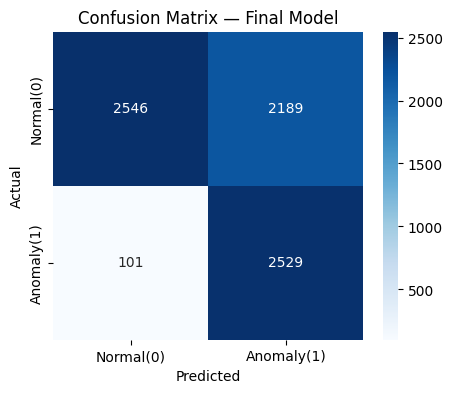


Classification Report:
               precision    recall  f1-score   support

           0     0.9618    0.5377    0.6898      4735
           1     0.5360    0.9616    0.6884      2630

    accuracy                         0.6891      7365
   macro avg     0.7489    0.7496    0.6891      7365
weighted avg     0.8098    0.6891    0.6893      7365

ROC-AUC: 0.9146838324747751


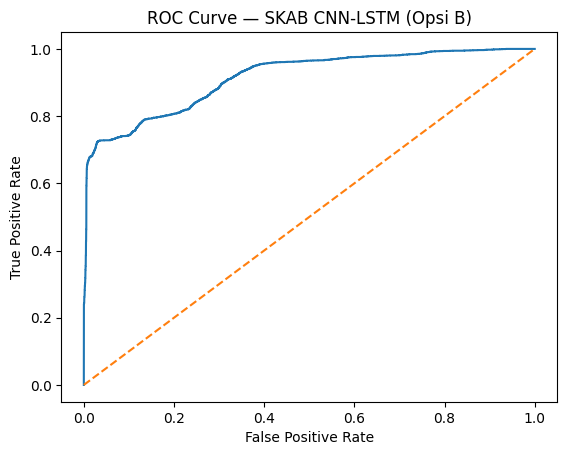

In [ ]:
y_prob = model.predict(X_test_w).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test_w, y_pred)
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal(0)", "Anomaly(1)"],
            yticklabels=["Normal(0)", "Anomaly(1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Final Model")
plt.show()

print("\nClassification Report:\n", classification_report(y_test_w, y_pred, digits=4))

auc = roc_auc_score(y_test_w, y_prob)
print("ROC-AUC:", float(auc))

fpr, tpr, _ = roc_curve(y_test_w, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SKAB CNN-LSTM (Opsi B)")
plt.show()


**Insight** :

Sebelum hyperparameter tuning, model cenderung **sangat sensitif terhadap kelas anomali** (recall 0,9616) namun menghasilkan **false positive tinggi** pada kelas normal, tercermin dari recall normal yang rendah (0,5377). Meski **ROC-AUC 0,9146** menunjukkan kemampuan pemisahan kelas yang baik, ketidakseimbangan precision–recall menandakan performa klasifikasi belum optimal dan masih perlu penyesuaian parameter.


# HYPERPARAMETER TUNING (GRID SEARCH)

In [ ]:
# =========================================================
# GRID SEARCH (manual loop) - SKAB CNN-LSTM
# =========================================================

# 1) Kandidat parameter yang mau diuji
lstm_candidates = [32, 64, 128]
dropout_candidates = [0.2, 0.3, 0.4]

EPOCHS_SEARCH = 35
BATCH_SIZE = 256

best_score = -1.0
best_params = {}

print("Mulai Grid Search...")
print(f"Total kombinasi: {len(lstm_candidates) * len(dropout_candidates)}")
print("=" * 50)

def create_model(lstm_units=64, dropout_rate=0.3):

    return build_cnn_lstm(
        input_shape=input_shape,
        filters=32,
        kernel_size=5,
        lstm_units=lstm_units,
        dropout=dropout_rate,
        lr=1e-3
    )

for units in lstm_candidates:
    for drop in dropout_candidates:
        print(f"\n[Training] Menguji kombinasi: LSTM={units}, Dropout={drop} ...")

        model = create_model(lstm_units=units, dropout_rate=drop)

        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_auc", mode="max",
            patience=3, restore_best_weights=True
        )

        history = model.fit(
            X_train_w, y_train_w,
            epochs=EPOCHS_SEARCH,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            class_weight=class_weight,
            callbacks=[es],
            verbose=1
        )

        # Ambil skor terbaik selama training (bukan epoch terakhir)
        val_auc_best = float(max(history.history["val_auc"]))
        print(f"--> Hasil AUC Validasi (best): {val_auc_best:.4f}")

        if val_auc_best > best_score:
            best_score = val_auc_best
            best_params = {"lstm_units": units, "dropout_rate": drop}
            print(">>> Hasil Terbaik sementara")

print("\n" + "=" * 50)
print("Grid Search Selesai.")
print("Parameter Terbaik:", best_params)
print(f"Skor Terbaik (val_auc): {best_score:.4f}")
print("=" * 50)


Mulai Grid Search...
Total kombinasi: 9

[Training] Menguji kombinasi: LSTM=32, Dropout=0.2 ...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6564 - auc: 0.6241 - loss: 0.6471 - val_accuracy: 0.3681 - val_auc: 0.5801 - val_loss: 0.8136
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6303 - auc: 0.7537 - loss: 0.5419 - val_accuracy: 0.3681 - val_auc: 0.5962 - val_loss: 0.7764
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6372 - auc: 0.7619 - loss: 0.5304 - val_accuracy: 0.3681 - val_auc: 0.6158 - val_loss: 0.8022
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6417 - auc: 0.7714 - loss: 0.5249 - val_accuracy: 0.3681 - val_auc: 0.6475 - val_loss: 0.8347
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6619 - auc: 0.7885 - loss: 0.5029 - val_accuracy: 0.4145 - val_auc: 0.9053 - val_loss: 0.6554
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6808 - auc: 0.8098 - loss: 0.4862 -

**Insight:**

Hasil Grid Search menunjukkan bahwa konfigurasi terbaik diperoleh pada **LSTM dengan 128 unit dan dropout 0,3**, yang mampu memberikan keseimbangan optimal antara kapasitas model dan pencegahan overfitting. Nilai **val_AUC sebesar 0,9686** mengindikasikan performa model yang sangat baik dalam membedakan kelas pada data validasi.


##Re-train

Training Final Model dengan LSTM=128 & Dropout=0.3
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6611 - auc: 0.6691 - loss: 0.6227 - val_accuracy: 0.3681 - val_auc: 0.5807 - val_loss: 0.7876
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6268 - auc: 0.7561 - loss: 0.5231 - val_accuracy: 0.3681 - val_auc: 0.5475 - val_loss: 0.8020
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6280 - auc: 0.7662 - loss: 0.5206 - val_accuracy: 0.7495 - val_auc: 0.8255 - val_loss: 0.6484
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6402 - auc: 0.7681 - loss: 0.5137 - val_accuracy: 0.3681 - val_auc: 0.6666 - val_loss: 0.7885
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6459 - auc: 0.7907 - loss: 0.5009 - val_accuracy: 0.3681 - val_auc: 0.6211 - val_loss: 0.7600
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6256 - auc: 0.7410 - loss: 0.5647 - val_accuracy: 0.7616 - val_auc: 0.8130 - 

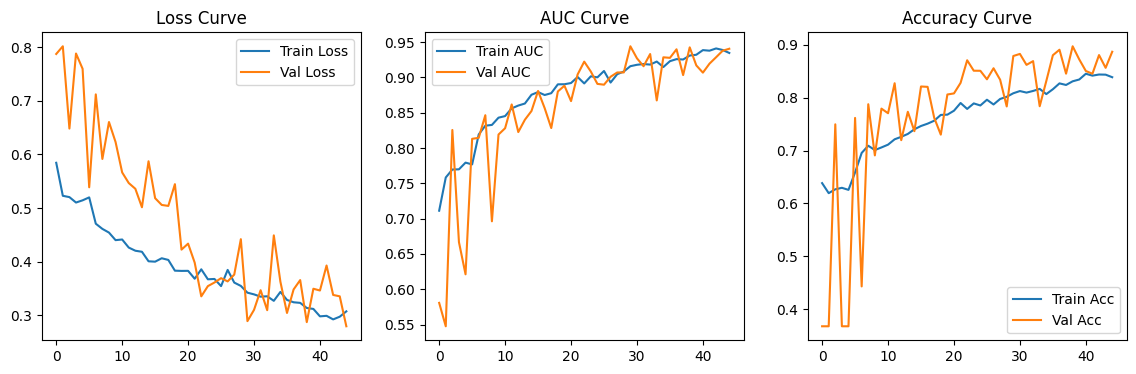

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Ambil parameter terbaik
final_units = int(best_params.get("lstm_units", 64))
final_dropout = float(best_params.get("dropout_rate", 0.3))

print(f"Training Final Model dengan LSTM={final_units} & Dropout={final_dropout}")

# Re-build model bersih
final_model = create_model(lstm_units=final_units, dropout_rate=final_dropout)

# Callbacks (konsisten dengan tuning: val_auc)
early_stop = EarlyStopping(
    monitor="val_auc", mode="max",
    patience=15, restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "best_hybrid_model.keras",
    monitor="val_auc", mode="max",
    save_best_only=True
)

# Full Training
history_final = final_model.fit(
    X_train_w, y_train_w,
    epochs= 50 ,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Plot Training History (Loss + AUC + Accuracy)
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(history_final.history["loss"], label="Train Loss")
plt.plot(history_final.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_final.history["auc"], label="Train AUC")
plt.plot(history_final.history["val_auc"], label="Val AUC")
plt.title("AUC Curve")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_final.history["accuracy"], label="Train Acc")
plt.plot(history_final.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


**Insight:**

Hasil re-train menunjukkan proses pembelajaran yang stabil, ditandai dengan **penurunan loss train dan validation secara konsisten** serta jarak keduanya yang relatif kecil, sehingga indikasi overfitting dapat diminimalkan. Nilai **val_AUC (~0,94) dan val_accuracy (~0,89)** yang terus meningkat dan mendekati performa data latih menegaskan bahwa model mampu melakukan generalisasi dengan baik pada data validasi.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


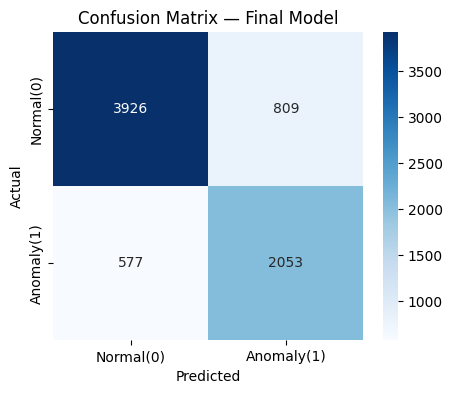


=== CLASSIFICATION REPORT (Final) ===
              precision    recall  f1-score   support

           0     0.8719    0.8291    0.8500      4735
           1     0.7173    0.7806    0.7476      2630

    accuracy                         0.8118      7365
   macro avg     0.7946    0.8049    0.7988      7365
weighted avg     0.8167    0.8118    0.8134      7365

ROC-AUC (Final): 0.9023


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# (Opsional tapi disarankan) Load model terbaik dari checkpoint
best_model = tf.keras.models.load_model("best_hybrid_model.keras")

# Prediksi probabilitas
y_prob = best_model.predict(X_test_w, batch_size=256).ravel()

# Threshold default 0.5
y_pred = (y_prob >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test_w, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal(0)", "Anomaly(1)"],
            yticklabels=["Normal(0)", "Anomaly(1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Final Model")
plt.show()


# Classification Report
print("\n=== CLASSIFICATION REPORT (Final) ===")
print(classification_report(y_test_w, y_pred, digits=4))

# (Tambahan yang penting untuk anomali) ROC-AUC
auc = roc_auc_score(y_test_w, y_prob)
print(f"ROC-AUC (Final): {auc:.4f}")


**Insight:**

Confusion matrix dan classification report menunjukkan model mampu mengklasifikasikan data dengan baik, dengan **akurasi 81,18% dan ROC-AUC 0,9023**. Performa pada kelas Anomali masih lebih menantang, namun **recall 0,7806** menandakan model cukup efektif dalam mendeteksi sebagian besar kasus anomali.


# BASELINE (SVM)

=== BASELINE: LINEAR SVM ===


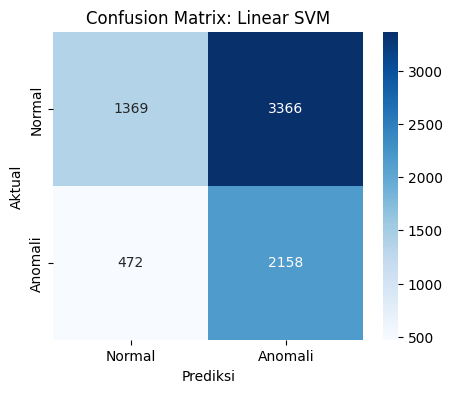


Classification Report:
               precision    recall  f1-score   support

           0     0.7436    0.2891    0.4164      4735
           1     0.3907    0.8205    0.5293      2630

    accuracy                         0.4789      7365
   macro avg     0.5671    0.5548    0.4728      7365
weighted avg     0.6176    0.4789    0.4567      7365

ROC-AUC: 0.5919615676480862


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.svm import LinearSVC

# pastikan X_train_stats, X_test_stats sudah dibuat dari window_to_stats()
svm = LinearSVC(class_weight="balanced", random_state=42)
svm.fit(X_train_stats, y_train_w)

svm_score = svm.decision_function(X_test_stats)   # skor kontinu
svm_pred  = (svm_score >= 0).astype(int)

print("=== BASELINE: LINEAR SVM ===")


cm_svm = confusion_matrix(y_test_w, svm_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_svm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Normal", "Anomali"],
    yticklabels=["Normal", "Anomali"]
)
plt.title("Confusion Matrix: Linear SVM")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

print("\nClassification Report:\n", classification_report(y_test_w, svm_pred, digits=4))
print("ROC-AUC:", float(roc_auc_score(y_test_w, svm_score)))


**Insight:**

Baseline **Linear SVM** menunjukkan performa yang rendah dengan **akurasi 47,89% dan ROC-AUC 0,59**, menandakan kemampuan pemisahan kelas yang lemah. Model cenderung bias ke kelas anomali, terlihat dari **recall anomali tinggi (0,8205)** namun **recall normal sangat rendah (0,2891)**.


# Export

In [ ]:
import tensorflow as tf

best_model = tf.keras.models.load_model("best_hybrid_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_path = "skab_cnn_lstm_best_select_ops.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("Saved:", tflite_path)


Saved artifact at '/tmp/tmpmjek77t6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 8), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132741584552400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584553936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584552784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584553360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584555280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584555664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132741584554704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: skab_cnn_lstm_best_select_ops.tflite


# Inference

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

TFLITE_PATH = "skab_cnn_lstm_best_select_ops.tflite"
SEQ_LEN = 80
THRESH = 0.5  # threshold prediksi

# Load interpreter sekali
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
in_det = interpreter.get_input_details()
out_det = interpreter.get_output_details()

def tflite_predict_prob(x_window_3d):
    x_window_3d = x_window_3d.astype(in_det[0]["dtype"])
    interpreter.set_tensor(in_det[0]["index"], x_window_3d)
    interpreter.invoke()
    y_out = interpreter.get_tensor(out_det[0]["index"])
    return float(y_out.ravel()[0])

def infer_last_window_skab(df_file, feature_cols, scaler, seq_len=80, thresh=0.5, rule="any", min_ratio=0.1):
    """
    rule:
      - "any": label aktual window = 1 jika ada minimal 1 anomaly di window
      - "ratio": label aktual window = 1 jika rasio anomaly >= min_ratio
    """
    if len(df_file) < seq_len:
        raise ValueError(f"Data kurang: butuh >= {seq_len} baris, ada {len(df_file)}.")

    # features
    X = df_file[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0).values
    Xw = X[-seq_len:].astype(np.float32)
    Xw = scaler.transform(Xw).astype(np.float32).reshape(1, seq_len, len(feature_cols))

    # prediction
    prob = tflite_predict_prob(Xw)
    pred = int(prob >= thresh)

    # ground truth window
    y = pd.to_numeric(df_file["anomaly"], errors="coerce").fillna(0).astype(int).values[-seq_len:]
    if rule == "ratio":
        gt = int(y.mean() >= min_ratio)
    else:
        gt = int(np.any(y == 1))

    return {
        "prob_anomaly": prob,
        "pred": pred,
        "gt": gt,
        "gt_anom_count": int(y.sum()),
        "window_len": seq_len
    }

# ====== Pakai: pilih file_id yang mau diuji ======
FILE_ID = file_stats.index[0]  # ganti manual jika mau
df_file = data[data["file_id"] == FILE_ID].copy()

res = infer_last_window_skab(df_file, feature_cols, scaler, seq_len=SEQ_LEN, thresh=THRESH, rule="any")

print(f"[Inference] file_id={FILE_ID}")
if "datetime" in df_file.columns:
    print("end_time:", df_file["datetime"].iloc[-1])
print(f"prob_anomaly={res['prob_anomaly']:.4f} | pred={res['pred']} | gt={res['gt']} | gt_anom_in_window={res['gt_anom_count']}/{res['window_len']}")
print("decision:", "ANOMALY" if res["pred"]==1 else "NORMAL")


[Inference] file_id=SKAB/other/11.csv
end_time: 2020-03-01 16:43:52
prob_anomaly=0.1038 | pred=0 | gt=0 | gt_anom_in_window=0/80
decision: NORMAL


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/tmp/ipython-input-1311226610.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_file[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0).values
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


/tmp/ipython-input-4116856322.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_file[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0).values.astype(np.float32)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,end_index,prob,pred,datetime_end
0,79,0.467139,0,2020-03-01 16:29:38
1,84,0.403089,0,2020-03-01 16:29:43
2,89,0.435240,0,2020-03-01 16:29:48
3,94,0.407727,0,2020-03-01 16:29:54
4,99,0.431585,0,2020-03-01 16:29:59


pred_anomaly_windows: 72 / 118


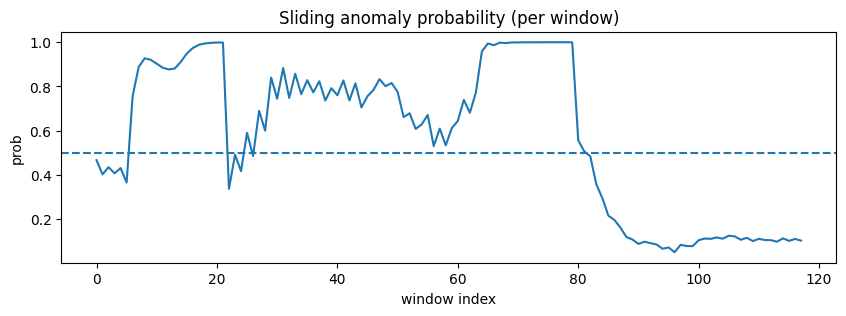

In [ ]:
def infer_sliding_skab(df_file, feature_cols, scaler, seq_len=80, stride=5, thresh=0.5):
    X = df_file[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0).values.astype(np.float32)
    Xs = scaler.transform(X).astype(np.float32)

    probs = []
    ends = []
    for start in range(0, len(df_file) - seq_len + 1, stride):
        end = start + seq_len
        xw = Xs[start:end].reshape(1, seq_len, len(feature_cols))
        probs.append(tflite_predict_prob(xw))
        ends.append(end - 1)

    out = pd.DataFrame({
        "end_index": ends,
        "prob": probs,
        "pred": (np.array(probs) >= thresh).astype(int)
    })
    if "datetime" in df_file.columns:
        out["datetime_end"] = df_file.iloc[ends]["datetime"].values
    return out

out = infer_sliding_skab(df_file, feature_cols, scaler, seq_len=SEQ_LEN, stride=5, thresh=THRESH)
display(out.head())

print("pred_anomaly_windows:", int(out["pred"].sum()), "/", len(out))

# Plot sederhana
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(out["prob"].values)
plt.axhline(THRESH, linestyle="--")
plt.title("Sliding anomaly probability (per window)")
plt.xlabel("window index")
plt.ylabel("prob")
plt.show()


**Insight:**

Hasil inferensi menunjukkan model mendeteksi **72 dari 118 window** sebagai anomali, dengan probabilitas yang secara konsisten melampaui ambang **0,5** pada segmen tertentu. Pola ini mengindikasikan model mampu menangkap periode anomali secara temporal, meskipun terdapat fluktuasi probabilitas di awal yang perlu dikaji lebih lanjut.
